# 2.Set up

In [177]:
# load data
from google.colab import files
uploaded = files.upload()

Saving datahomework2.xls to datahomework2 (1).xls


In [33]:
# set up
!pip install xlrd
!pip install cvxpy==0.4.11
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from cvxpy import *

# PART A:

In [0]:
price = pd.read_excel("datahomework2.xls")

# 1.Prepare Data

## A. Calculate Return Rates

In [295]:
return_rate = price /price.shift(1) - 1.0# with first row as NaN
return_rate = return_rate.drop(return_rate.index[0])
return_rate.head(5) # return rates first 5 rows

,Amazon,Apple,Ebay,Facebook,Google,Twitter
1,-0.028097,0.000094,-0.012827,-0.013473,-0.024832,0.024739
2,0.033924,0.014022,-0.001727,0.000000,-0.002764,0.048552
3,0.008723,0.038422,0.027037,0.026592,0.003365,0.027628
4,-0.010667,0.001073,-0.013828,-0.005565,-0.012231,-0.019915
5,-0.028460,-0.024641,-0.007726,-0.013121,-0.007190,0.007112


## B. Compute Average Return Rates

In [296]:
return_rate_mean = (return_rate+1.0).agg(np.prod) ** (1.0/len(return_rate.index)) -1.0
print("mean return rate:")
return_rate_mean

mean return rate:


Amazon      0.001988
Apple       0.000626
Ebay        0.000755
Facebook    0.001088
Google      0.000974
Twitter    -0.000028
dtype: float64

## C. Compute Variance-Covariance Matrix of Stock Returns

In [297]:
return_rate_cov = return_rate.cov()
return_rate_cov

,Amazon,Apple,Ebay,Facebook,Google,Twitter
Amazon,0.000407,0.000005,0.000012,-0.000011,0.000007,-0.000095
Apple,0.000005,0.000211,0.000060,0.000069,0.000060,0.000040
Ebay,0.000012,0.000060,0.000292,0.000027,0.000055,0.000024
Facebook,-0.000011,0.000069,0.000027,0.000242,0.000099,0.000022
Google,0.000007,0.000060,0.000055,0.000099,0.000203,0.000010
Twitter,-0.000095,0.000040,0.000024,0.000022,0.000010,0.001071


## D. Provide vector $\mu$ and  Variance-Covariance Matrix $\Sigma$ for 6 assets considered

In [0]:
# Convert pandas series and data frame to list and array
mu = np.array(return_rate_mean.tolist())
sigma = return_rate_cov.as_matrix()

# 2. Portfolio Optimization: Minimizing Risk

In [299]:
required_return = ((1+0.07) ** (1.0/365))-1
x1 = Variable(6)
obj = Minimize(quad_form(x1, sigma))
constraints = [mu*x1 >= required_return,
              sum_entries(x1) == 1.0,
              x >= 0.0]
prob = Problem(objective=obj, 
               constraints=constraints)
prob.solve()

7.834645802543038e-05

In [300]:
print("portfolio allocations are:")
print(x1.value)

portfolio allocations are:
[[0.20424887]
 [0.19549525]
 [0.16170007]
 [0.17375729]
 [0.18985702]
 [0.07494149]]


# 3. Portfolio Optimization: Maximizing Returns

In [304]:
for gamma in [0.1,0.15,0.2]:
  x2 = Variable(6)
  obj = Maximize(mu.T*x2-gamma*quad_form(x2,sigma)) # cannot take square root of quad_form.
  constraints = [mu*x2 >= required_return,
                sum_entries(x2) == 1.0,
                x2 >= 0.0]
  prob = Problem(objective=obj, 
                 constraints=constraints)
  prob.solve()
  print("while gamma = "+str(gamma)+" :")
  print("allocation is:")
  print(x2.value)
  print("max annual return is:")
  print(str(round(((prob.solve() + 1) ** 365 - 1)*100))+"%")
  print("\n")

while gamma = 0.1 :
allocation is:
[[9.99999988e-01]
 [2.48040601e-09]
 [2.45998515e-09]
 [1.74915269e-09]
 [2.11875083e-09]
 [3.52254798e-09]]
max annual return is:
103.0%


while gamma = 0.15 :
allocation is:
[[9.99999996e-01]
 [6.75033810e-10]
 [6.68835156e-10]
 [7.06892795e-10]
 [6.17596925e-10]
 [1.27817908e-09]]
max annual return is:
102.0%


while gamma = 0.2 :
allocation is:
[[9.99999993e-01]
 [9.61569016e-10]
 [1.04693811e-09]
 [2.10451687e-09]
 [1.36376086e-09]
 [1.84087577e-09]]
max annual return is:
100.0%




# 4. Simulations

Minimize Risk:
mean: 136661.2571383137
var: 340798829.05457914


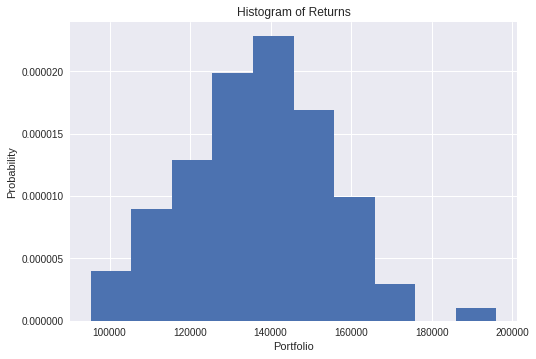

In [262]:
simu=100 # 100 simulations
T = 300 # 300 trading days
m=6 # 6 stocks
B=100000 # Budget
x = x1 # first senerio, minimize risk
print("Minimize Risk:")
z_values = []
for q in range(simu):
   y = np.zeros((T+1,m))
   y[0]=[x.value.item(0),x.value.item(1),x.value.item(2),x.value.item(3),\
         x.value.item(4), x.value.item(5)]
   for i in range(T):
       rr=np.random.multivariate_normal(mu,sigma)
       y[i+1]=y[i]*(1+rr)
   z_values.append(sum(y[T])*B)

print("mean: "+str(np.mean(z_values)))
print("var: "+str(np.var(z_values)))
plt.hist(z_values, density=True )
plt.xlabel('Portfolio')
plt.ylabel('Probability')
plt.title('Histogram of Returns')
plt.show()

Maximize Profit:
mean: 179428.2102909254
var: 3334443186.564652


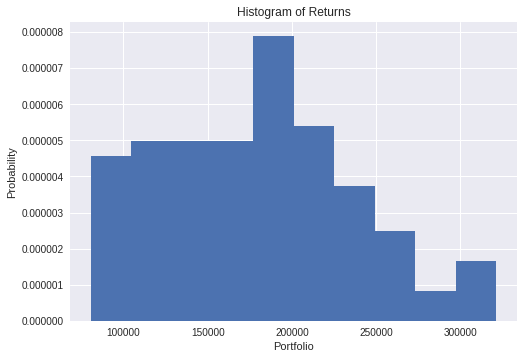

In [263]:
simu=100 # 100 simulations
T = 300 # 300 trading days
m=6 # 6 stocks
B=100000 # Budget
x = x2 # first senerio, minimize risk
print("Maximize Profit:")
z_values = []
for q in range(simu):
   y = np.zeros((T+1,m))
   y[0]=[x.value.item(0),x.value.item(1),x.value.item(2),x.value.item(3),\
         x.value.item(4), x.value.item(5)]
   for i in range(T):
       rr=np.random.multivariate_normal(mu,sigma)
       y[i+1]=y[i]*(1+rr)
   z_values.append(sum(y[T])*B)

print("mean: "+str(np.mean(z_values)))
print("var: "+str(np.var(z_values)))
plt.hist(z_values, density=True )
plt.xlabel('Portfolio')
plt.ylabel('Probability')
plt.title('Histogram of Returns')
plt.show()

# 5. Recommendations

## a. Explain the difference in allocations

The goal of portfolio 1 is to minimize risk, so the alloction is very diverse, so the risks from different stocks can cancel out each other.

While the goal of portfolio 2 is to maximize return, so the investor needs to expose himself/herself in higher risk.

## b. recommendations for investors with different risk aversion $\gamma$

If the investor wants to minimize risk, he or she should  have more diversification over the portfolio(weight: 0.20424887,0.19549525,0.16170007,0.17375729,0.18985702,0.07494149). So the risk of stocks can cancel out each other.

If the investor wants to maximize the returns from the portofil while considering risks, the investor should expose himself/herselt to higher risks. As Amazon's stock price increase very fast. From all our optimization, we found that, no matter the risk avrsion(from 0.1 to 0.2), the investor should invest in Amazon (99.9999% of the portfolio).

As long as the risk aversion of investor is between 0.1 and 0.2. They investor should invest most in the Amazon stock(more than 99.99%).

# PART B:

# 1.Prepare Data

In [0]:
# Use last 400 days
price = pd.read_excel("datahomework2.xls")
price = price.iloc[-400:,:]

## A. Calculate Return Rates

In [306]:
return_rate = price /price.shift(1) - 1.0# with first row as NaN
return_rate = return_rate.drop(return_rate.index[0])
return_rate.head(5) # return rates first 5 rows

,Amazon,Apple,Ebay,Facebook,Google,Twitter
400,-0.015032,0.015207,0.010625,0.006353,0.012142,0.067554
401,-0.002854,0.008281,-0.007646,0.000879,-0.002107,-0.022052
402,0.015332,0.004060,-0.001284,-0.001597,0.002794,-0.011274
403,0.008462,-0.007444,0.000321,-0.001439,0.001251,-0.058007
404,-0.000682,-0.000648,0.002571,0.000160,-0.000359,-0.001053


## B. Compute Average Return Rates

In [307]:
return_rate_mean = (return_rate+1.0).agg(np.prod) ** (1.0/len(return_rate.index)) -1.0
print("mean return rate:")
return_rate_mean

mean return rate:


Amazon      0.001464
Apple       0.001261
Ebay        0.000806
Facebook    0.000980
Google      0.000873
Twitter     0.001503
dtype: float64

## C. Compute Variance-Covariance Matrix of Stock Returns

In [308]:
return_rate_cov = return_rate.cov()
return_rate_cov

,Amazon,Apple,Ebay,Facebook,Google,Twitter
Amazon,2.300889e-04,-0.000010,-3.671180e-07,-0.000002,-9.316626e-07,-0.000034
Apple,-9.806561e-06,0.000140,6.598452e-06,0.000003,6.913915e-06,-0.000011
Ebay,-3.671180e-07,0.000007,2.367480e-04,-0.000013,1.879560e-06,-0.000026
Facebook,-2.030910e-06,0.000003,-1.321101e-05,0.000159,2.138099e-05,-0.000002
Google,-9.316626e-07,0.000007,1.879560e-06,0.000021,1.224945e-04,-0.000005
Twitter,-3.373240e-05,-0.000011,-2.619704e-05,-0.000002,-5.323036e-06,0.001004


## D. Provide vector $\mu$ and  Variance-Covariance Matrix $\Sigma$ for 6 assets considered

In [0]:
# Convert pandas series and data frame to list and array
mu = np.array(return_rate_mean.tolist())
sigma = return_rate_cov.as_matrix()

# 2. Portfolio Optimization: Minimizing Risk

In [310]:
required_return = ((1+0.07) ** (1.0/365))-1
x1 = Variable(6)
obj = Minimize(quad_form(x1, sigma))
constraints = [mu*x1 >= required_return,
              sum_entries(x1) == 1.0,
              x >= 0.0]
prob = Problem(objective=obj, 
               constraints=constraints)
prob.solve()

3.304433596238752e-05

In [311]:
print("portfolio allocations are:")
print(x1.value)

portfolio allocations are:
[[0.16292247]
 [0.22948999]
 [0.1473746 ]
 [0.18903736]
 [0.22488624]
 [0.04628934]]


# 3. Portfolio Optimization: Maximizing Returns

In [312]:
for gamma in [0.1,0.15,0.2]:
  x2 = Variable(6)
  obj = Maximize(mu.T*x2-gamma*quad_form(x2,sigma)) # cannot take square root of quad_form, otherwise return error
  constraints = [mu*x2 >= required_return,
                sum_entries(x2) == 1.0,
                x2 >= 0.0]
  prob = Problem(objective=obj, 
                 constraints=constraints)
  prob.solve()
  print("while gamma = "+str(gamma)+" :")
  print("allocation is:")
  print(x2.value)
  print("max annual return is:")
  print(str(round(((prob.solve() + 1) ** 365 - 1)*100))+"%")
  print("\n")

while gamma = 0.1 :
allocation is:
[[6.47945849e-01]
 [3.76112562e-08]
 [4.77535640e-08]
 [5.22277353e-08]
 [4.89317505e-08]
 [3.52053964e-01]]
max annual return is:
70.0%


while gamma = 0.15 :
allocation is:
[[6.97885273e-01]
 [6.36066591e-08]
 [1.75592283e-08]
 [2.38633781e-08]
 [1.94541517e-08]
 [3.02114603e-01]]
max annual return is:
70.0%


while gamma = 0.2 :
allocation is:
[[7.22460850e-01]
 [5.02504163e-07]
 [1.19930332e-07]
 [1.67492644e-07]
 [1.34175116e-07]
 [2.77538225e-01]]
max annual return is:
69.0%




# 4. Simulations

Minimize Risk:
mean: 140848.71581755028
var: 203387851.97965172


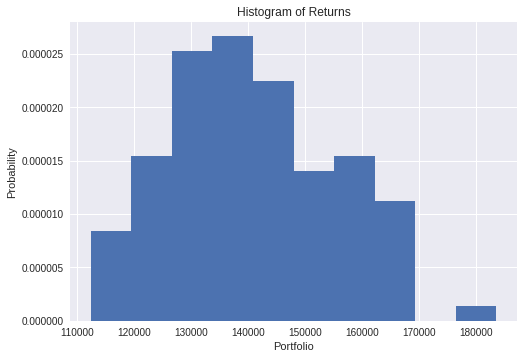

In [313]:
simu=100 # 100 simulations
T = 300 # 300 trading days
m=6 # 6 stocks
B=100000 # Budget
x = x1 # first senerio, minimize risk
print("Minimize Risk:")
z_values = []
for q in range(simu):
   y = np.zeros((T+1,m))
   y[0]=[x.value.item(0),x.value.item(1),x.value.item(2),x.value.item(3),\
         x.value.item(4), x.value.item(5)]
   for i in range(T):
       rr=np.random.multivariate_normal(mu,sigma)
       y[i+1]=y[i]*(1+rr)
   z_values.append(sum(y[T])*B)

print("mean: "+str(np.mean(z_values)))
print("var: "+str(np.var(z_values)))
plt.hist(z_values, density=True )
plt.xlabel('Portfolio')
plt.ylabel('Probability')
plt.title('Histogram of Returns')
plt.show()

Maximize Profit:
mean: 154868.2067357917
var: 1574105843.286802


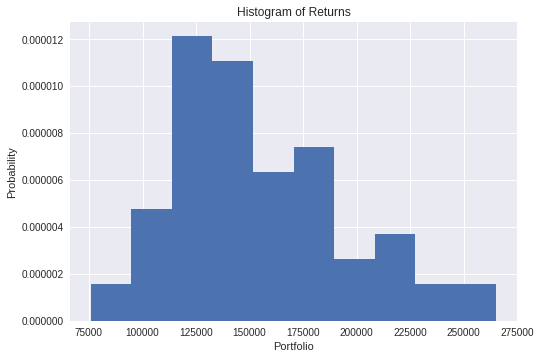

In [314]:
simu=100 # 100 simulations
T = 300 # 300 trading days
m=6 # 6 stocks
B=100000 # Budget
x = x2 # first senerio, minimize risk
print("Maximize Profit:")
z_values = []
for q in range(simu):
   y = np.zeros((T+1,m))
   y[0]=[x.value.item(0),x.value.item(1),x.value.item(2),x.value.item(3),\
         x.value.item(4), x.value.item(5)]
   for i in range(T):
       rr=np.random.multivariate_normal(mu,sigma)
       y[i+1]=y[i]*(1+rr)
   z_values.append(sum(y[T])*B)

print("mean: "+str(np.mean(z_values)))
print("var: "+str(np.var(z_values)))
plt.hist(z_values, density=True )
plt.xlabel('Portfolio')
plt.ylabel('Probability')
plt.title('Histogram of Returns')
plt.show()

# 5. Recommendations

## a. Explain the difference in allocations

The goal of portfolio 1 is to minimize risk, so the alloction is very diverse, so the risks from different stocks can cancel out each other.

While the goal of portfolio 2 is to maximize return, so the investor needs to expose himself/herself in higher risk.

## b. recommendations for investors with different risk aversion $\gamma$

If the investor wants to minimize risk:  He or she should have more diversification over investments with weight: 0.16292247,0.22948999,0.1473746,0.18903736,0.22488624,0.04628934.

Consider risk aversion, if the investor wants to  maximize portfolio return,  for investor who has risk aversion of 0.1, 0.15 and 0.2, The investor should invest around:  
65%,70%,72% in Amazon, and 35%, 30% 28% in Twitter.

## c.Why are the allocations different




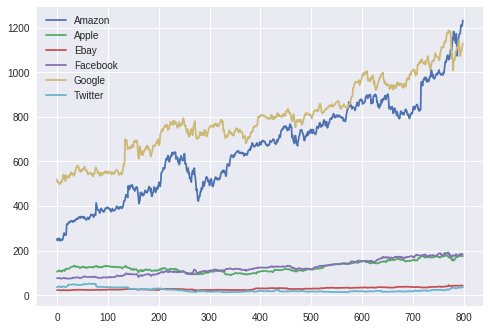

In [316]:
price = pd.read_excel("datahomework2.xls")
price.plot()

The allocation difference betwwen using full time series and only last four hundred days are:

When using only last four hundred days, optimization sugguest that investor should invest less in Amazon, because during the last 400 days, Amazon's stock price are more volatile.